In [247]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
HUES = {}
HUES["GCN-Transformer"] = "Red"
HUES["GCN-Sys-Hist"] = "Red"
HUES["GCN-Sys"] = "Purple"
HUES["GCN-Hist"] = "Grey"

HUES["GCN-Avg"] = "Purple"
HUES["GCN"] = "Black"


#HUES["DBMS (instance-tuned)"] = "Gray"

HUES["GCN-Pretrained-Latent"] = "Blue"
HUES["GCN-Pretrained"] = "Green"
HUES["GCN-PretrainedT-CurrentDB"] = "Gray"
HUES["GCN-PretrainedT-NoCurrentDB"] = "Green"
HUES["GCN-PreatinedT-NoCurrentDB-NoActualFeats"] = "Black"

In [249]:
api = wandb.Api()

In [250]:
#bdfs

In [251]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      #{"config.eval_epoch": 5},
      #{"config.traindata_dir": "LatencyCollectorResults/background"},
      #{"config.traindata_dir": "LatencyCollectorResults/new"},
      {"$or": [
            {"$and": [
                {"tags":"stack_query_split4"},
            ]},
#           {
#             "config.config":  "configs/baselines/config_avg.yaml",
#           },
#           {
#             "config.config":  "configs/baselines/config_trans.yaml",
#           },
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 10 runs


In [252]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  0.03211688995361328
8


In [253]:
df = pd.concat(dfs)
df = pd.concat([df, bdf])
print(len(df))

10


In [254]:
set(df["alg"])

{'dbms', 'dbms-all', 'nn'}

In [255]:
# GCN, GCN-Transformer, GCN-Pretrained, GCN-Pretrained-Latent

def get_alg(row):
    if "dbms" == row["alg"]:
        return "DBMS (instance-tuned)"
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    elif "avg" in row["config"]:
        return "GCN-Avg"
    elif row["arch"] == "gcn":
        return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["sys_net_arch"] == "transformer" and row["hist_net_arch"] == "transformer":
            return "GCN-Sys-Hist"
        elif row["sys_net_arch"] == "none" and row["hist_net_arch"] == "transformer":
            return "GCN-Hist"
        elif row["sys_net_arch"] == "transformer":
            return "GCN-Sys"
        else:
            assert False
    
    elif "evals" in row["config"]:
        if "latent_variable" in row and row["latent_variable"] == 1 and row["latent_inference"] == 1:
            return "GCN-Pretrained-Latent"
        elif row["sys_net_pretrained_fn"] == "models2/noimdb_wk_128.wt":
            return "GCN-Pretrained"
        elif row["sys_net_pretrained_fn"] == "models2/noimdb_128_fixed.wt":
            return None
        else:
            return "GCN-Pretrained" 
            # + row["sys_net_pretrained_fn"]
            #return None
            #return "GCN-PretrainedT-NoCurrentDB"
        
        #return row["sys_net_pretrained_fn"]
    else:
        return None
    
def get_workload(row):
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
     
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

In [256]:
set(df["sys_net_pretrained"])

{0}

In [257]:
df = df[df["alg"].notna()]

In [258]:
print(len(df))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print(set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))

10
{1}
{1}
{'configs/query_splits/stack/config_hist.yaml', 'configs/baselines/config_dbms_stack.yaml', 'configs/query_splits/stack/config_trans.yaml', 'configs/query_splits/stack/config_sys.yaml'}
{None}
{'GCN-Sys', 'DBMS (instance-tuned)', 'GCN', 'GCN-Hist', 'DBMS-all', 'GCN-Sys-Hist'}
{'exp10_single_zdbs,exp5_single_stats,exp8_single_stack, exp11_single_zdbs,exp9_single_tpch, exp4_single_ergast,exp1_single,exp2_single,exp3_single ', 'exp8_single_stack,exp2_stack,exp9_stack1,exp9_stack2'}
{'Stack'}


In [259]:
df = df[df["config"].isin(['configs/query_splits/stack/config_trans.yaml', 
                           'configs/query_splits/stack/config_hist.yaml',
                           'configs/query_splits/stack/config_sys.yaml'])]

#df = df[df["config"] == 'configs/query_splits/imdb/config_trans.yaml']

In [260]:
df.keys()

Index(['Tags', 'name', 'lr', 'alg', 'hl1', 'arch', 'seed', 'tags', 'config',
       'min_est',
       ...
       'hist_net_hl', 'hist_net_arch', 'hist_net_dropout', 'hist_net_max_pool',
       'hist_net_num_heads', 'hist_net_num_layers', 'hist_net_pretrained',
       'hist_net_save_weights', 'test_query_dir', 'workload'],
      dtype='object', length=133)

In [261]:
#df = df[df["weight_decay"] == 0.1]

In [262]:
pd.set_option('display.max_rows', 500)

#tmp = df[df["num_instances"] == 1]
df[["seed", "num_instances", "alg", "num_epochs", "lr", "Final-LatencyQError-test-mean", "Final-LatencyAE-test-mean" , "weight_decay", "Final-LatencyMSE-test-mean", 
    "Final-LatencyQError-test-median", "Final-LatencyQError-test-99p"]].sort_values(by="seed")

,seed,num_instances,alg,num_epochs,lr,Final-LatencyQError-test-mean,Final-LatencyAE-test-mean,weight_decay,Final-LatencyMSE-test-mean,Final-LatencyQError-test-median,Final-LatencyQError-test-99p
0,1,1,GCN-Sys,50,0.00010,3.381341,72.131690,0.1,15216.575944,2.100079,18.059687
0,1,1,DBMS (instance-tuned),50,0.00001,7.879297,107.091956,0.1,27506.791502,3.823001,62.167609
0,1,1,GCN,50,0.00010,5.370696,98.899282,0.1,23720.600346,2.897160,30.284876
0,1,1,GCN-Sys-Hist,50,0.00010,3.473176,76.373858,0.1,16366.236826,2.235569,15.968887
0,1,1,GCN-Sys,50,0.00010,3.380461,77.811181,0.1,16567.466646,2.270775,18.280737
0,1,1,GCN-Hist,50,0.00010,4.188439,87.080095,0.1,20862.912848,2.596379,27.684946
0,1,1,GCN-Sys-Hist,50,0.00010,3.287153,73.612323,0.1,15719.111094,2.186657,14.662334
0,1,1,GCN-Hist,50,0.00010,6.217700,87.064900,0.1,23044.595585,2.985939,49.796598


In [263]:
# tmp = df[df["num_instances"] == 2]
# tmp[["seed", "num_instances", "alg", "Final-LatencyQError-test-mean", "Final-LatencyAE-test-mean" , "weight_decay", "Final-LatencyMSE-test-mean", 
#     "Final-LatencyQError-test-median", "Final-LatencyQError-test-99p"]].sort_values(by="seed")

In [264]:
# FN_TMP = "{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="ci"
#     TO_PLOT = ['Final-LatencyMSE-test-median', 'Final-LatencyMSE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     ## train
#     ax = axs[0]
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
#                 ax=ax, errorbar=EB, 
#                 palette=HUES)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                        frameon=False)

#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
#                 errorbar=EB, palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyQError-test-median', 'Final-LatencyQError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
#     ## train
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                palette=HUES)
#     #axs[0].legend().remove()
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
#                palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

Query-Splits-Stack-Latency-MSE.pdf
Query-Splits-Stack-Latency-Q-Error.pdf
Query-Splits-Stack-Latency-Relative-Error.pdf
Query-Splits-Stack-Latency-Absolute-Error.pdf


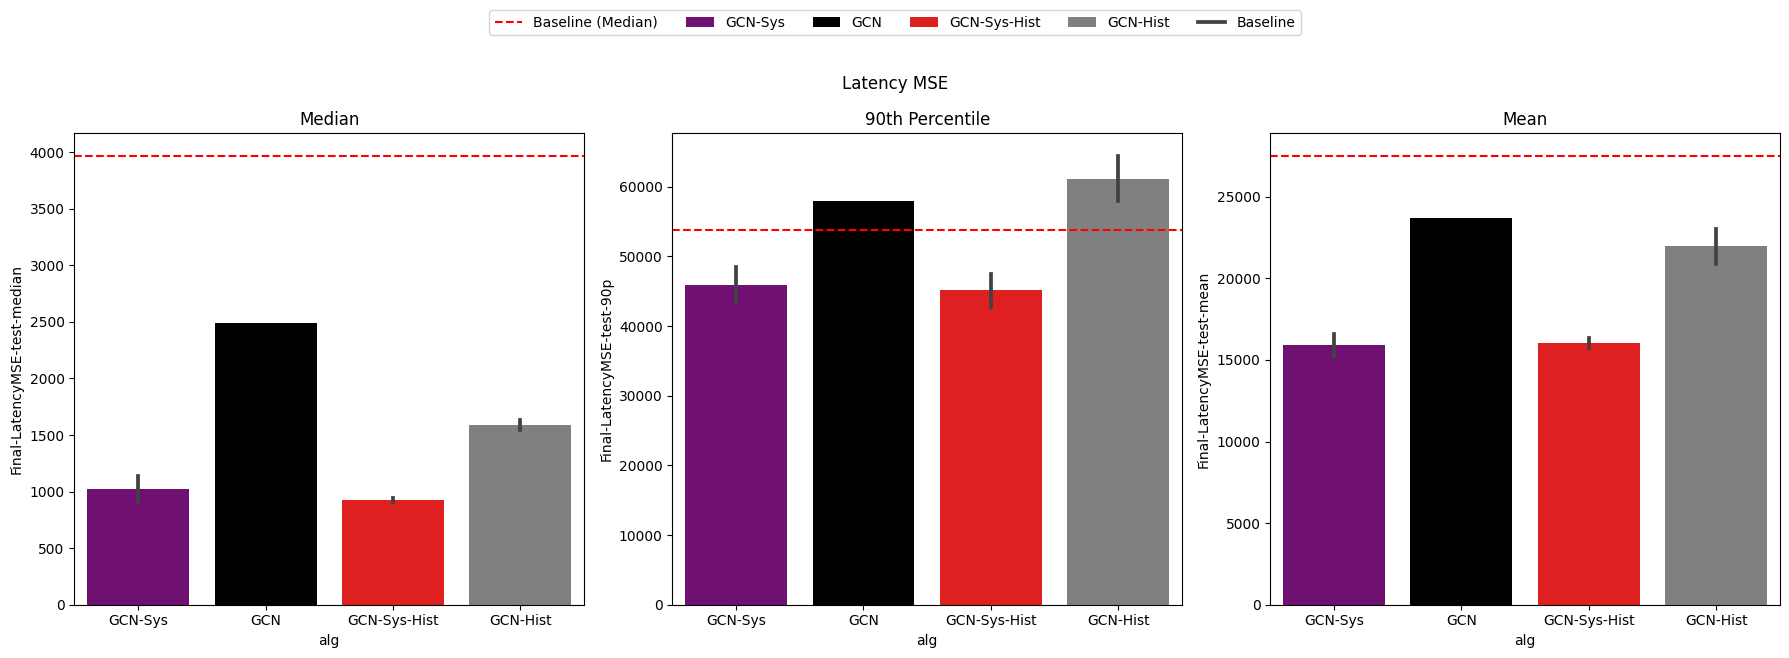

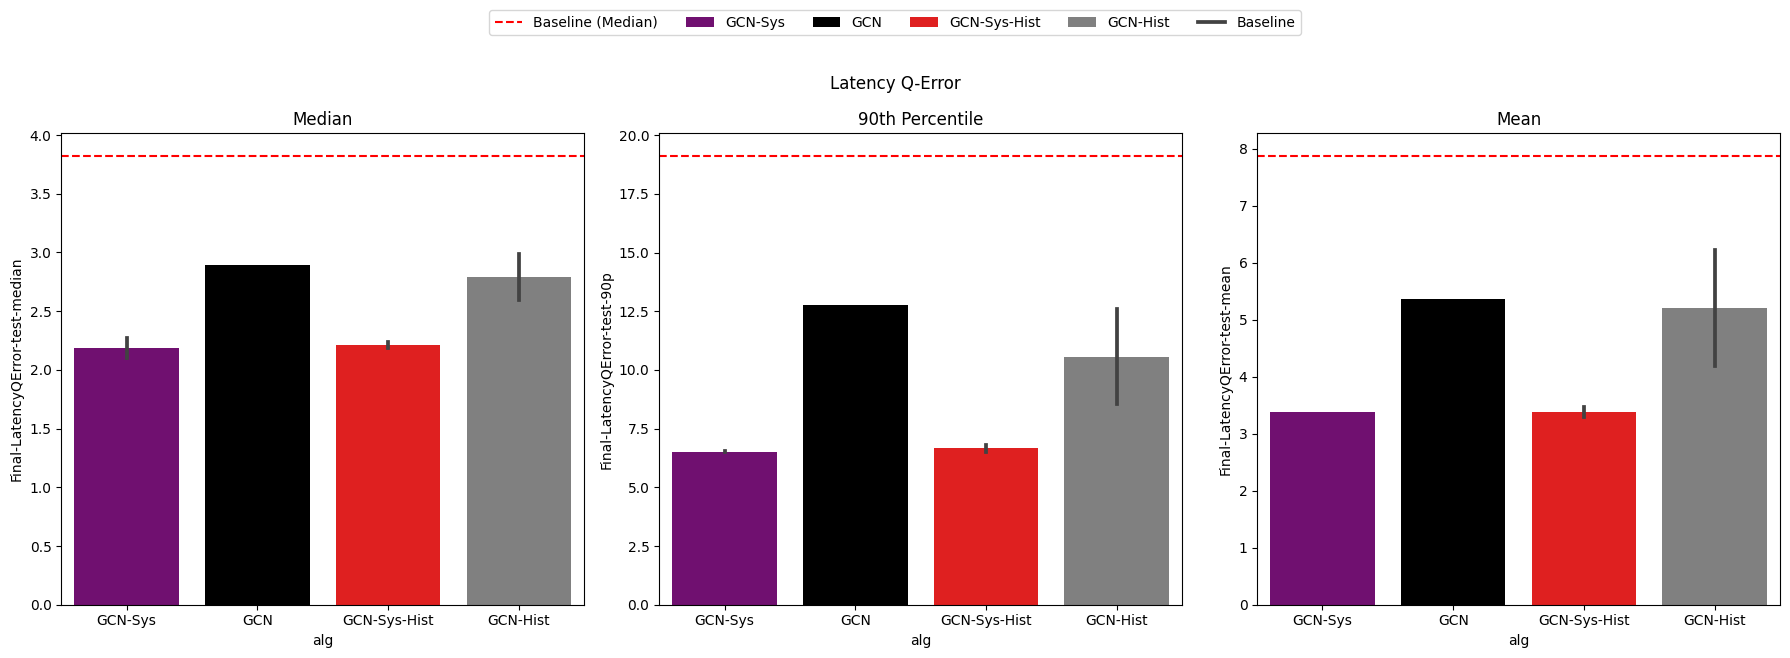

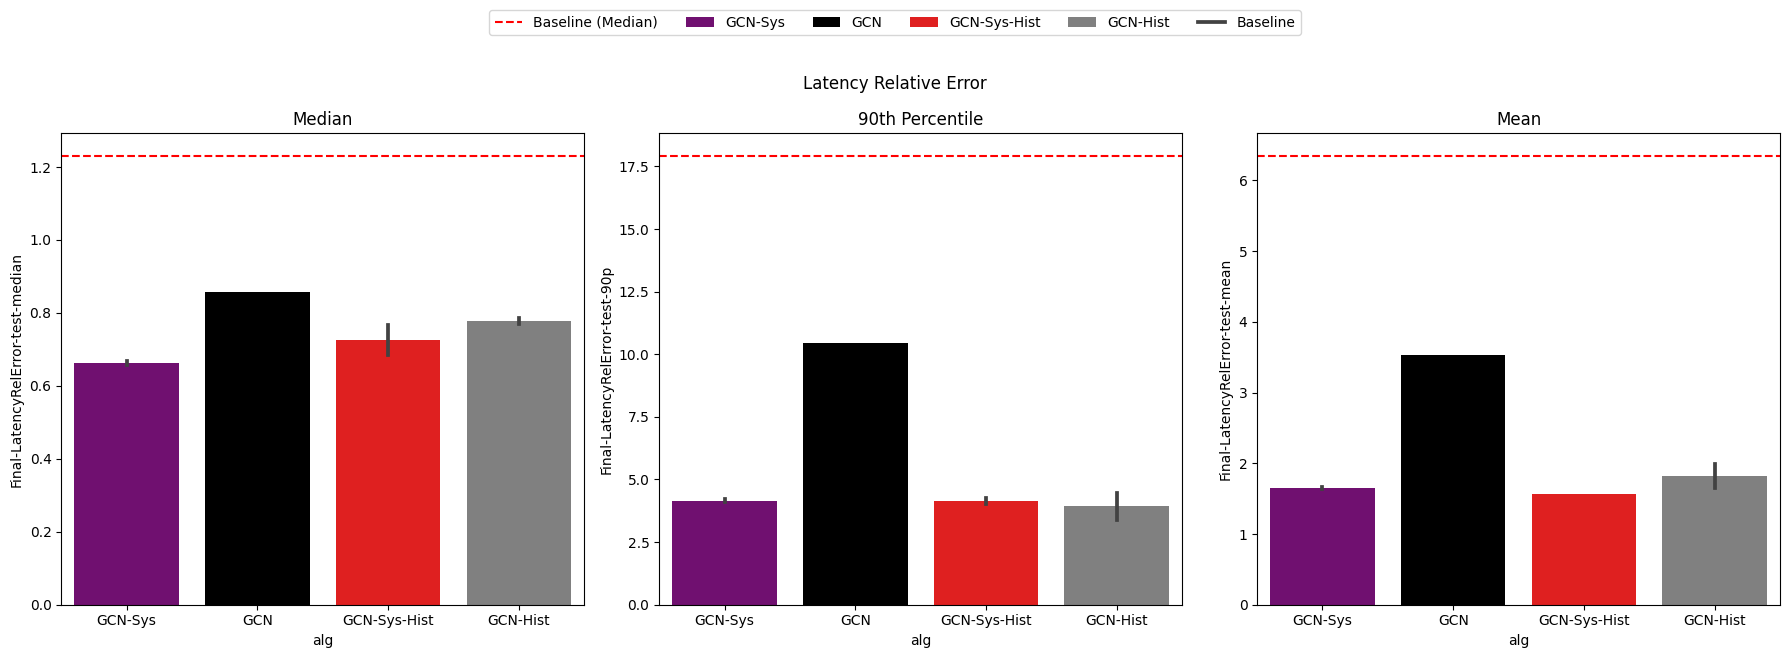

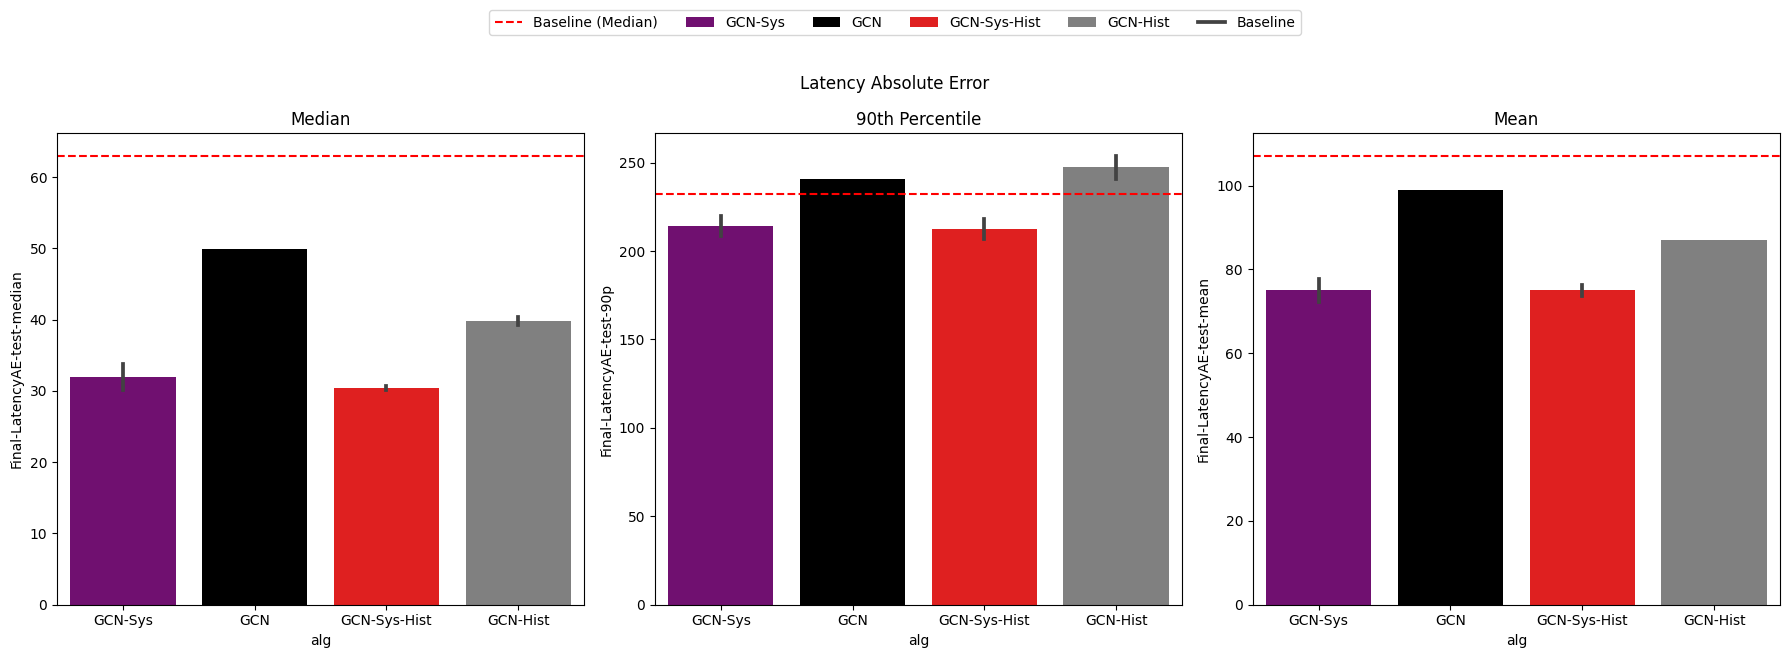

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns

FN_TMP = "Query-Splits-{}-{}.pdf"

# Define a function to check if the values have a large range and should be plotted in log scale
def should_use_log_scale(values):
    return max(values) / min(values) > 1000  # Adjust this threshold if needed
    
def plot_metrics(data, metric_median, metric_90p, metric_mean, title):
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(title)
    
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    # Filter out the baseline data from the data being plotted
    data = data[data['alg'] != "DBMS (instance-tuned)"]
    
    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    # Plot for Median values
    sns.barplot(data=data, y=metric_median, 
                x="alg",
                hue="alg", dodge=False, ax=axs[0], palette=HUES)
    if baseline_median is not None:
        axs[0].axhline(baseline_median, color='r', linestyle='--', label='Baseline (Median)')
    axs[0].set_title('Median')
    
#     if should_use_log_scale(data[metric_median]):
#         axs[0].set_yscale("log")
        
    # Plot for 90th Percentile values
    sns.barplot(data=data, y=metric_90p, 
                x="alg", 
                hue="alg", 
                dodge=False, ax=axs[1], palette=HUES)
    if baseline_90p is not None:
        axs[1].axhline(baseline_90p, color='r', linestyle='--', label='Baseline (90th Percentile)')
    axs[1].set_title('90th Percentile')
    
#     if should_use_log_scale(data[metric_90p]):
#         axs[1].set_yscale("log")

    # Plot for Mean values
    sns.barplot(data=data, y=metric_mean, 
                x="alg", 
                hue="alg", dodge=False, ax=axs[2], palette=HUES)
    if baseline_mean is not None:
        axs[2].axhline(baseline_mean, color='r', linestyle='--', label='Baseline (Mean)')
    axs[2].set_title('Mean')
#     if should_use_log_scale(data[metric_mean]):
#         axs[2].set_yscale("log")

    # Remove individual legends and add a single legend at the top
    for ax in axs:
        ax.get_legend().remove()
        
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.10), ncol=len(handles) + 1)

    # Finalize the plot and save
    plt.tight_layout()
    fn = FN_TMP.format(wk, title.replace(' ', '-'))
    print(fn)
    plt.savefig(fn, bbox_inches="tight")

# Loop through each unique workload
for wk in set(df["workload"]):
    tmp = df[df["workload"] == wk]
    
    # Plot for MSE
    plot_metrics(tmp, 
                 'Final-LatencyMSE-test-median', 
                 'Final-LatencyMSE-test-90p', 
                 'Final-LatencyMSE-test-mean',
                 'Latency MSE')

    # Plot for Q-Error
    plot_metrics(tmp, 
                 'Final-LatencyQError-test-median', 
                 'Final-LatencyQError-test-90p', 
                 'Final-LatencyQError-test-mean',
                 'Latency Q-Error')
    
    plot_metrics(tmp, 
                 'Final-LatencyRelError-test-median', 
                 'Final-LatencyRelError-test-90p', 
                 'Final-LatencyRelError-test-mean',
                 'Latency Relative Error')
    
    # Plot for AE
    plot_metrics(tmp, 
                 'Final-LatencyAE-test-median', 
                 'Final-LatencyAE-test-90p', 
                 'Final-LatencyAE-test-mean',
                 'Latency Absolute Error')


In [52]:
df[df['alg'] == "DBMS (instance-tuned)"]

,Tags,name,lr,alg,hl1,arch,seed,tags,config,min_est,...,Final-LatencyAE-train-90p,Final-LatencyMSE-test-mean,Final-LatencyMSE-train-median,Final-LatencyRelError-test-90p,Final-LatencyRelError-train-90p,epoch,train-train_loss,fact_net_pretrained,test_query_dir,workload
0,"[3a, query_split2]",quiet-wood-3549,0.00001,DBMS (instance-tuned),512,factorized,1,"exp8_single_stack,exp2_stack,exp9_stack1,exp9_...",configs/query_splits/stack/config_trans.yaml,None,...,181.109381,27506.791502,3638.588821,17.920776,26.668452,NaN,NaN,NaN,NaN,Stack


In [408]:
set(df["alg"])

{'GCN', 'GCN-Pretrained', 'GCN-Pretrained-Latent', 'GCN-Transformer'}

Stack-Latency-MSE.pdf
Stack-Latency-Q-Error.pdf
Stack-Latency-Relative-Error.pdf
Stack-Latency-Absolute-Error.pdf


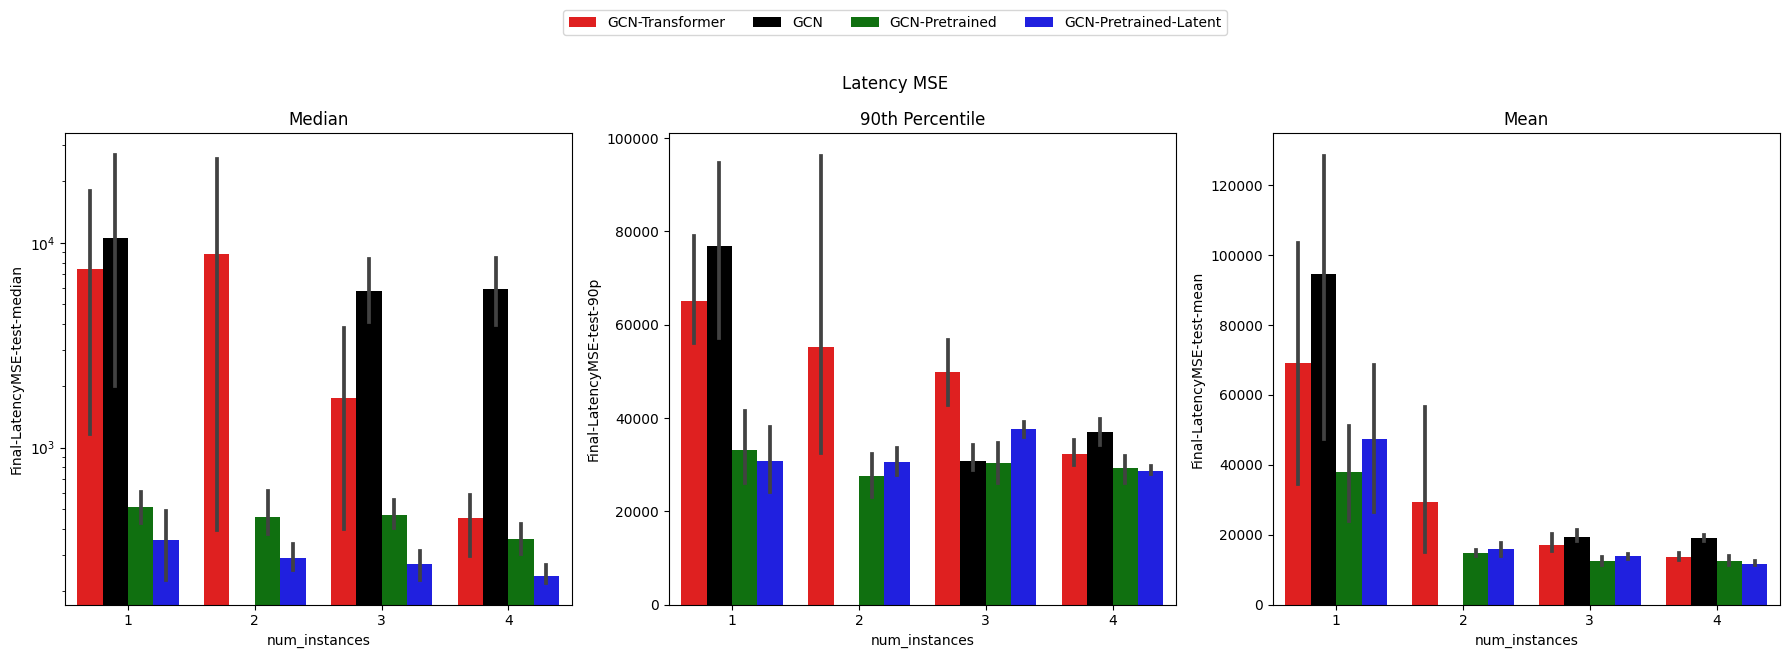

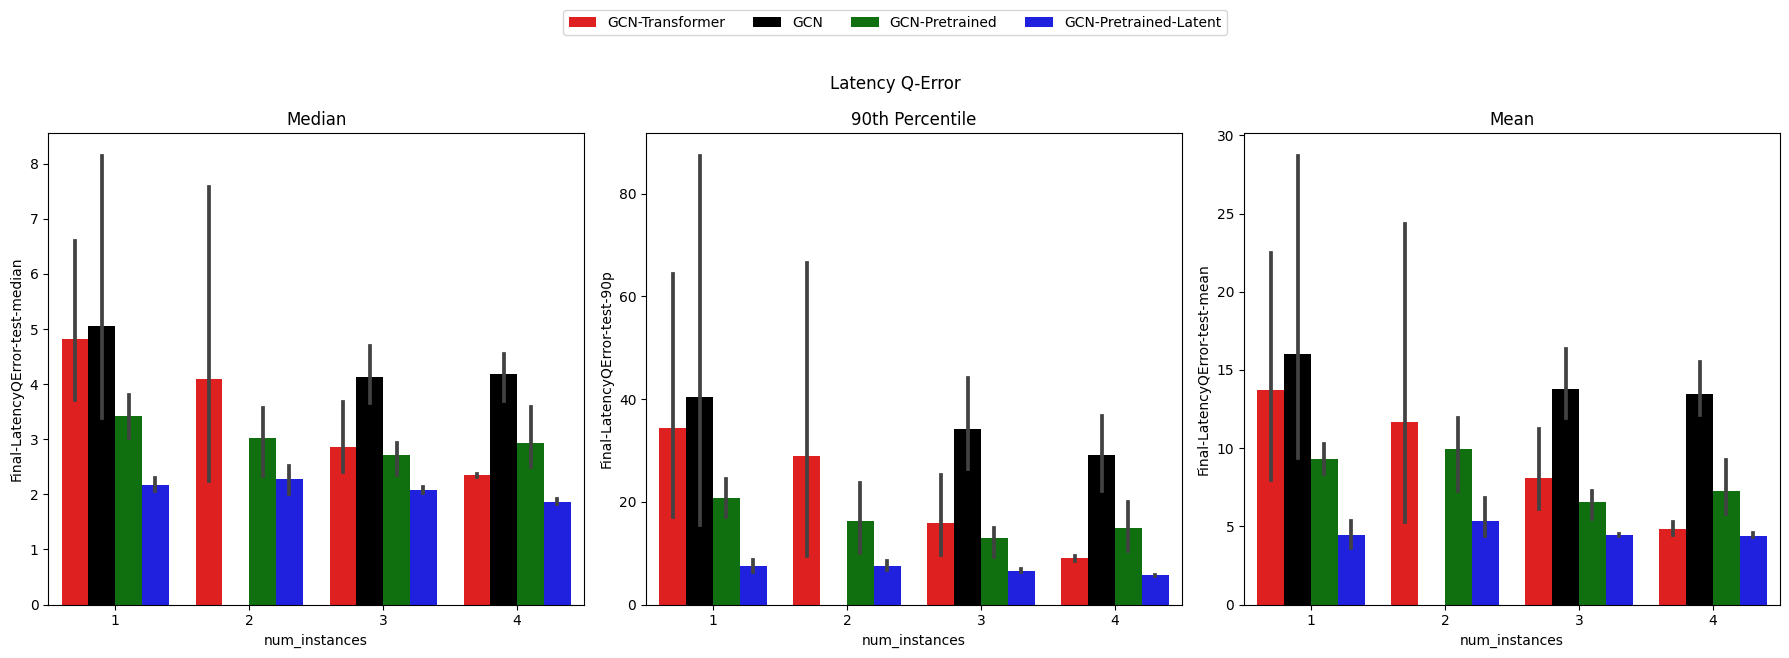

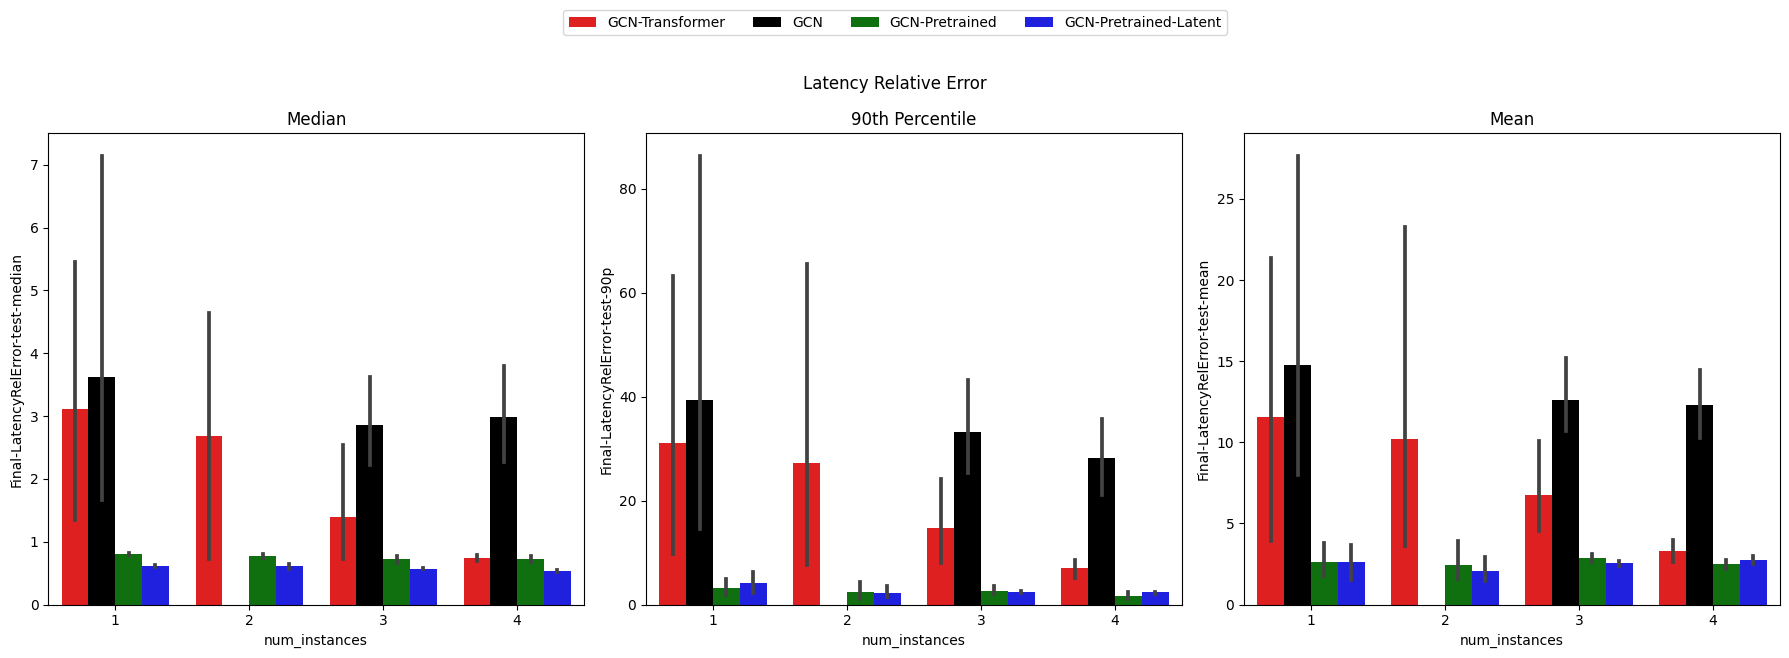

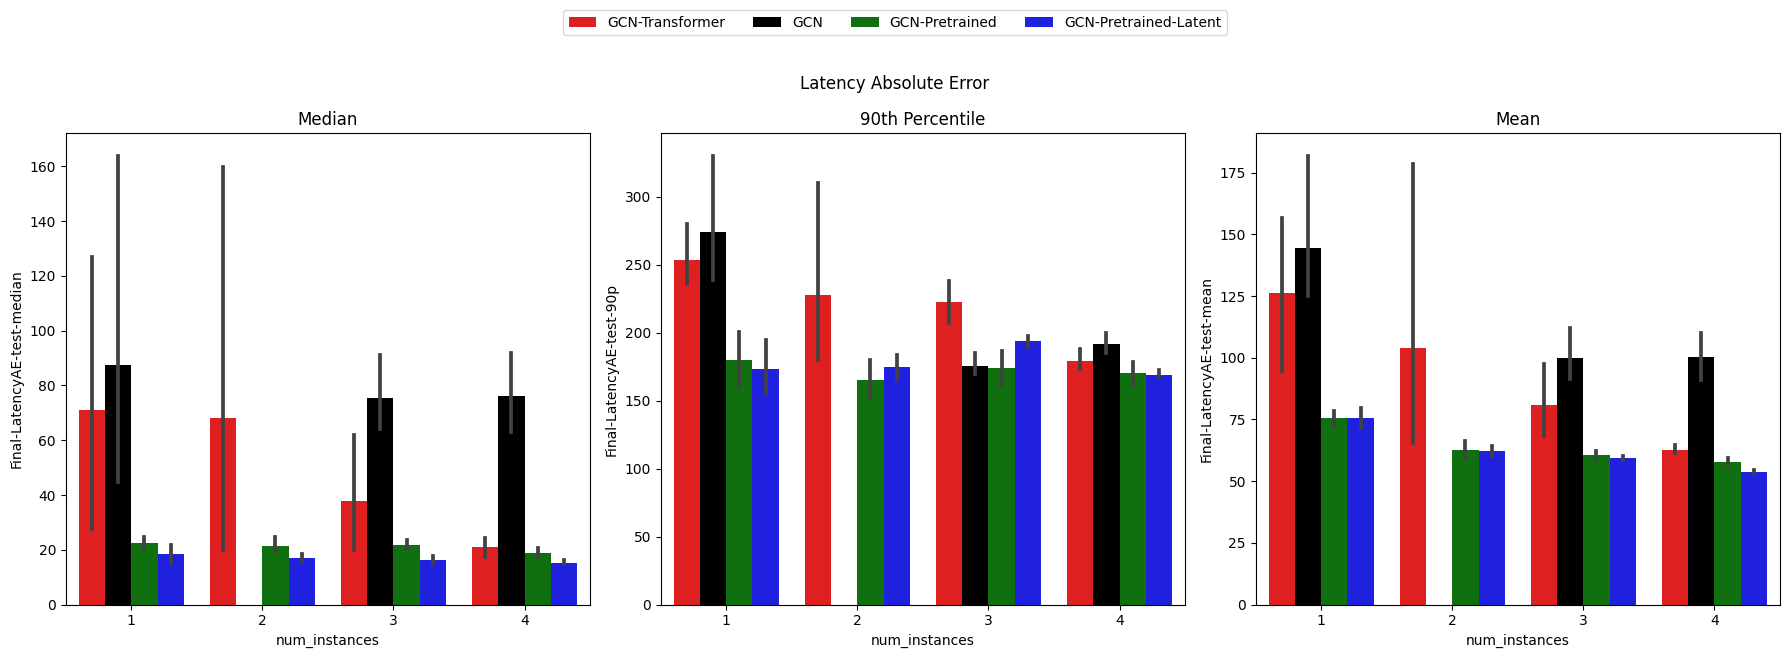

In [401]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# FN_TMP = "{}-{}.pdf"

# # Define a function to check if the values have a large range and should be plotted in log scale
# def should_use_log_scale(values):
#     return max(values) / min(values) > 100  # Adjust this threshold if needed

# # Define a function to plot the given metrics
# def plot_metrics(data, metric_median, metric_90p, metric_mean, title):
#     fig, axs = plt.subplots(1, 3, figsize=(18,6))
#     plt.suptitle(title)
    
#     # Plot for Median values
#     sns.barplot(data=data, y=metric_median, x="num_instances", hue="alg", dodge=True, ax=axs[0], palette=HUES)
#     axs[0].set_title('Median')
#     if should_use_log_scale(data[metric_median]):
#         axs[0].set_yscale("log")

#     # Plot for 90th Percentile values
#     sns.barplot(data=data, y=metric_90p, x="num_instances", hue="alg", dodge=True, ax=axs[1], palette=HUES)
#     axs[1].set_title('90th Percentile')
#     if should_use_log_scale(data[metric_90p]):
#         axs[1].set_yscale("log")

#     # Plot for Mean values
#     sns.barplot(data=data, y=metric_mean, x="num_instances", hue="alg", dodge=True, ax=axs[2], palette=HUES)
#     axs[2].set_title('Mean')
    
#     if should_use_log_scale(data[metric_mean]):
#         axs[2].set_yscale("log")

#     # Remove individual legends and add a single legend at the top
#     for ax in axs:
#         ax.get_legend().remove()
#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=len(handles))

#     # Finalize the plot and save
#     plt.tight_layout()
#     fn = FN_TMP.format(wk, title.replace(' ', '-'))
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

# # Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
#     # Plot for MSE
#     plot_metrics(tmp, 
#                  'Final-LatencyMSE-test-median', 
#                  'Final-LatencyMSE-test-90p', 
#                  'Final-LatencyMSE-test-mean',
#                  'Latency MSE')

#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyQError-test-median', 
#                  'Final-LatencyQError-test-90p', 
#                  'Final-LatencyQError-test-mean',
#                  'Latency Q-Error')

    
#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyRelError-test-median', 
#                  'Final-LatencyRelError-test-90p', 
#                  'Final-LatencyRelError-test-mean',
#                  'Latency Relative Error')
    
#     # Plot for AE
#     plot_metrics(tmp, 
#                  'Final-LatencyAE-test-median', 
#                  'Final-LatencyAE-test-90p', 
#                  'Final-LatencyAE-test-mean',
#                  'Latency Absolute Error')

Stack-MSE.pdf
Stack-Q-Error.pdf


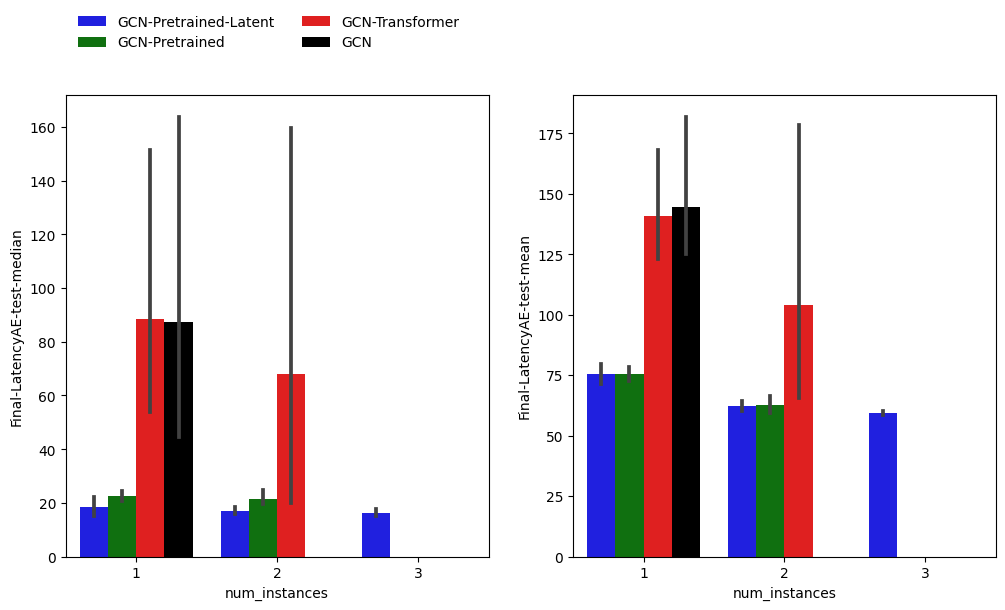

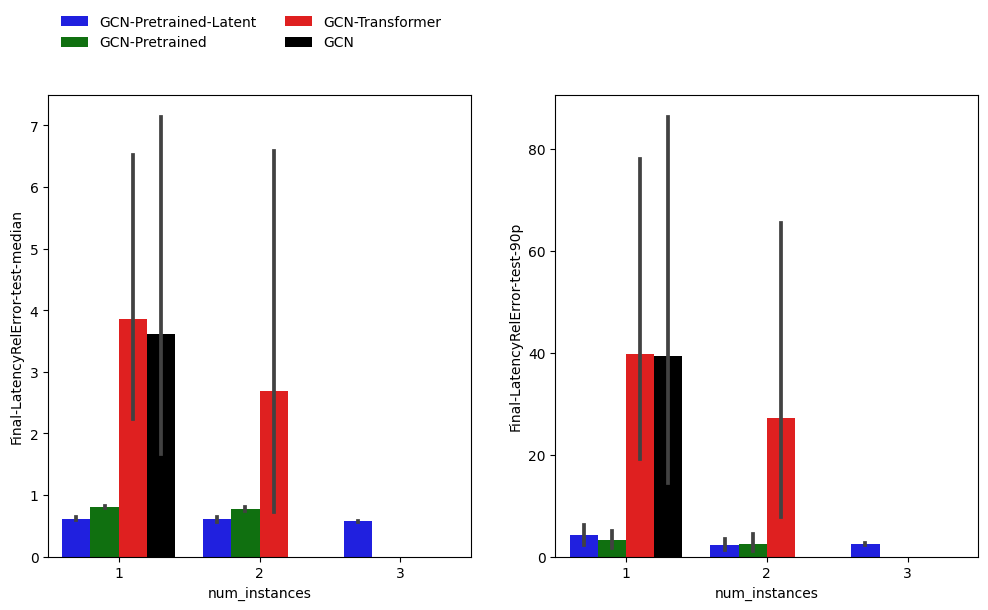

In [358]:
FN_TMP = "{}-{}.pdf"
for wk in set(df["workload"]):
    tmp = df[df["workload"] == wk]
    EB="ci"
    TO_PLOT = ['Final-LatencyAE-test-median', 'Final-LatencyAE-test-mean']
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    ## train
    ax = axs[0]
    sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
                ax=ax, errorbar=EB, 
                palette=HUES)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
                       frameon=False)

    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
                errorbar=EB, palette=HUES)
    axs[1].legend().remove()
    
    fn = FN_TMP.format(wk, "MSE")
    print(fn)
    plt.savefig(fn, bbox_inches="tight")
    
    TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    ## train
    sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
               palette=HUES)
    #axs[0].legend().remove()
    legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
               frameon=False)
    
    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
               palette=HUES)
    axs[1].legend().remove()
    
    fn = FN_TMP.format(wk, "Q-Error")
    print(fn)
    plt.savefig(fn, bbox_inches="tight")

Test-Stack-MSE.pdf
Test-Stack-Q-Error.pdf


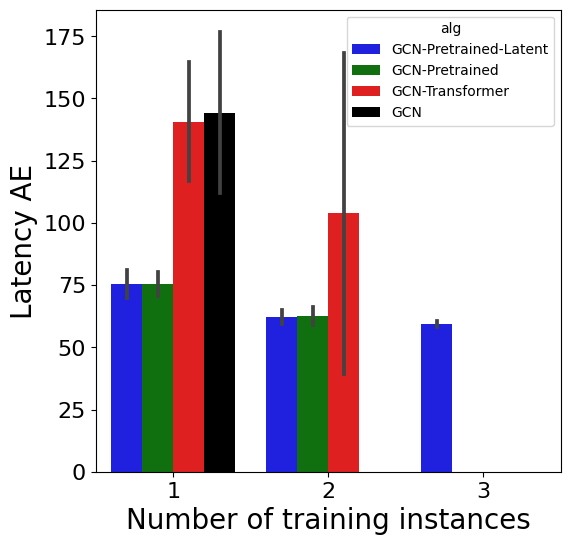

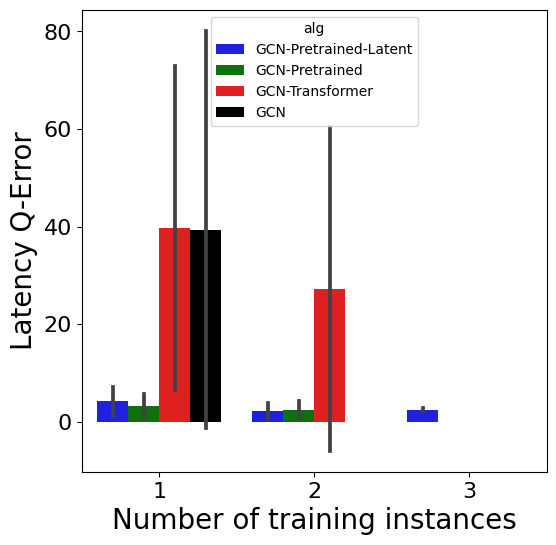

In [355]:
# FN_TMP = "Test-{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="sd"
#     TO_PLOT = ['Final-LatencyAE-train-mean', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#     ## train
# #     ax = axs[0]
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
# #                 ax=ax, errorbar=EB, palette=HUES)
# #     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                        frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=ax, 
#                 errorbar=EB, palette=HUES)
#     #axs[1].legend().remove()
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency AE", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    
#     ## train
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
# #                palette=HUES)
#     #axs[0].legend().remove()
# #     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs, errorbar=EB,
#                palette=HUES)
    
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency Rel-Error", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     #axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")